_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: Carlotta Trottenberg, Ralf Krüger, Jungmin Lee

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations
from scipy.stats import multivariate_normal

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-14 11:04:00BST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.23.0

sklearn: 1.4.2

numpy     : 1.26.4
scipy     : 1.13.0
matplotlib: 3.8.4

Watermark: 2.4.3



In [3]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [4]:
# replace by path to your solutions
b = np.load("../../../data/nds_cl_1_features.npy")
s = np.load("../../../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../../../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [5]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 2046
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # insert your code here

    # Sample cluster labels based on the probabilities
    labels = rng.choice(len(p), size=n_samples, p=p)

    # Initialize an array to store the generated samples
    x = np.zeros((n_samples, m.shape[1]))

    # Generate samples for each cluster
    for i in range(len(p)):
        # Select indices where the label equals i
        indices = np.where(labels == i)[0]

        # Sample from the multivariate normal distribution
        if len(indices) > 0:
            x[indices, :] = rng.multivariate_normal(m[i], S[i], size=len(indices))

    return labels, x

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------
    pass

In [6]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

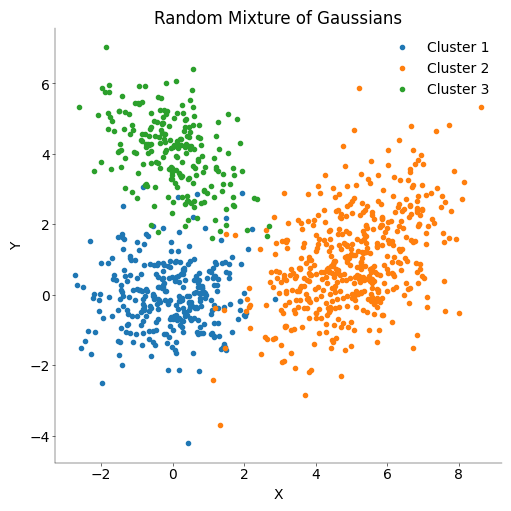

In [7]:
# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5))

for i in range(len(p)):
    # Select data points belonging to cluster i
    cluster_points = x[labels == i]

    # Plot the data points for this cluster
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")

# Add labels and legend
ax.set_title("Random Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [8]:
def fit_mog(
    x: np.ndarray, n_clusters: int, n_iters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # fill in your code here

    # -----------
    # init (1 pt)
    # -----------
    n_samples = len(x[:, 0])

    # k means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed, n_init=1).fit(x)
    m = kmeans.cluster_centers_
    labels = kmeans.labels_

    # get covs and p
    S = np.zeros((n_clusters, np.shape(x)[1], np.shape(x)[1]))
    p = np.zeros(n_clusters)
    for label in np.arange(n_clusters):
        S[label, :, :] = np.cov(x[labels == label, :].T)
        p[label] = len(x[labels == label, 0]) / n_samples
    N = np.zeros(n_clusters)
    r = np.zeros((x.shape[0], n_clusters))

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------

    for step in range(n_iters):
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`

        for j in range(n_clusters):
            r[:, j] = p[j] * sp.stats.multivariate_normal.pdf(x, m[j], S[j])

        # normalization
        r_sum = np.sum(r, axis=1)
        r /= r_sum[:, np.newaxis]

        # M step
        # Estimate new `m`, `S` and `p`
        for j in range(n_clusters):
            m[j] = np.sum(x * r[:, j, np.newaxis], axis=0) / np.sum(r[:, j])
            S[j] = np.dot((x - m[j]).T, (x - m[j]) * r[:, j, np.newaxis]) / np.sum(
                r[:, j]
            )
            p[j] = np.mean(r[:, j])

    # Assign labels based on the highest probability
    labels = np.argmax(r, axis=1)

    return labels, m, S, p

    pass

Run Mixture of Gaussian on toy data

In [9]:
mog_labels, m, S, p = fit_mog(x, 3, random_seed=0)

Plot toy data with cluster assignments and compare to original labels

Text(0.5, 1.0, 'MoG Model')

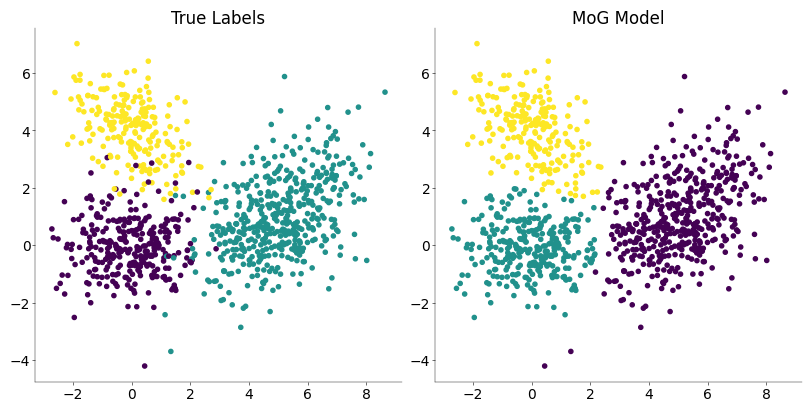

In [10]:
mosaic = [["True", "MoG"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")

# -----------------
# Add plot (0.5 pts)
# -----------------
# Plot True labels
ax["True"].scatter(x[:, 0], x[:, 1], c=labels)
ax["True"].set_title("True Labels")

# Plot MoG model
ax["MoG"].scatter(x[:, 0], x[:, 1], c=mog_labels)
ax["MoG"].set_title("MoG Model")

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [11]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """
    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    n_samples, n_dims = x.shape
    n_clusters = len(p)

    # Compute log-likelihood
    LL = 0
    for i in range(n_samples):
        likelihood_i = np.sum(
            p
            * np.array(
                [
                    sp.stats.multivariate_normal(m[j], S[j]).pdf(x[i])
                    for j in range(n_clusters)
                ]
            )
        )
        LL += np.log(likelihood_i)

    # get number of parameters
    n_params = n_clusters * (n_dims + n_dims * (n_dims + 1) // 2 + 1) - 1

    # get BIC
    bic = -2 * LL + n_params * np.log(n_samples)

    return bic, LL

    pass

In [12]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

K = range(2, 16)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

bic = np.zeros(num_seeds)
ll = np.zeros(num_seeds)

for i, k in enumerate(K):
    # for robustness against local minima, multiple initializations
    for seed in range(num_seeds):
        mog_labels, m, S, p = fit_mog(x, k, seed)
        bic[seed], ll[seed] = mog_bic(x, m, S, p)

    # Choose the model with the lowest BIC score
    best_model = np.argmin(bic)

    BIC[:, i], LL[:, i] = bic[best_model], ll[best_model]

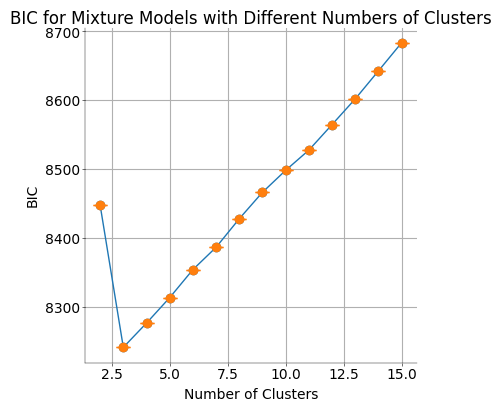

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC

ax.plot(K, np.mean(BIC, axis=0), marker="o", linestyle="-")
ax.errorbar(K, np.mean(BIC, axis=0), yerr=np.std(BIC, axis=0), fmt="o", capsize=5)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("BIC")
ax.set_title("BIC for Mixture Models with Different Numbers of Clusters")
ax.grid(True)
plt.show()

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [ ]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

K = range(2, 16)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here

bic = np.zeros(num_seeds)
ll = np.zeros(num_seeds)

for i, k in enumerate(K):
    # for robustness against local minima, multiple initializations
    for seed in range(num_seeds):
        mog_labels, m, S, p = fit_mog(b, k, seed)
        bic[seed], ll[seed] = mog_bic(b, m, S, p)

    # Choose the model with the lowest BIC score
    best_model = np.argmin(bic)

    BIC[:, i], LL[:, i] = bic[best_model], ll[best_model]

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

# plot BIC

ax.plot(K, np.mean(BIC, axis=0), marker="o", linestyle="-")
ax.errorbar(K, np.mean(BIC, axis=0), yerr=np.std(BIC, axis=0), fmt="o", capsize=5)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("BIC")
ax.set_title("BIC for Mixture Models with Different Numbers of Clusters")
ax.grid(True)
plt.show()

Refit model with lowest BIC and plot data points

In [ ]:
random_seed, kk = np.where(BIC == BIC.min())
random_seed = random_seed[0]
kk = kk[0]
print(f"lowest BIC: # cluster = {K[kk]}")

a, m, S, p = fit_mog(b, K[kk], random_seed=random_seed)

In [ ]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

# indices of the 1st PC
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

# choose colors for each label
colors = [plt.cm.Set2(each) for each in np.linspace(0, 1, len(np.unique(a)))]

# Find the axis with matching name in mosaic layout
for mo in np.ravel(mosaic):
    # skip subplot if necessary:
    if mo == ".":
        continue
    # select needed 1st PCs:
    y, x = mo.split(" vs ")
    
    # loop through all labels:
    for p, label in enumerate(np.unique(a)):
        # plot only points of this label, in label's color
        ax[mo].scatter(b[a==label, i[x]], b[a==label, i[y]], 0.5, color=colors[int(label)], alpha=0.2)
    
    # plot this cluster's mean in black
    ax[mo].scatter(m[:,i[x]],m[:,i[y]], s=1, color='k', alpha=1)


for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    # ax[mo].set_xlim((-100, 600))
    # ax[mo].set_ylim((-100, 600))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


In [39]:
def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    assignment: np.ndarray,
    n_bins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    n_bins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    # insert your code here

    n_spikes, n_features = b.shape
    n_clusters = len(np.unique(assignment))

    proj = np.zeros((n_bins, n_clusters, n_clusters))
    bins = np.zeros(n_bins)

    # ---------------------------------------------------------------------
    # compute the optimal separating axes for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            # Compute LDA axis
            lda_axis = np.linalg.inv(S[i] + S[j]) @ (m[i] - m[j])

            # -------------------------------------------
            # normalise according to first cluster (1 pt)
            # -------------------------------------------
            b_i = b[assignment == i]
            b_j = b[assignment == j]
            b_i_normalized = (b_i - m[i]) @ lda_axis
            b_j_normalized = (b_j - m[i]) @ lda_axis

            # --------------------------------------
            # plot histograms on optimal axis (1 pt)
            # --------------------------------------
            hist_i, bins = np.histogram(b_i_normalized, bins=n_bins, density=True)
            hist_j, _ = np.histogram(b_j_normalized, bins=bins, density=True)

            # Save histogram
            proj[:, i, j] = hist_i
            proj[:, j, i] = hist_j

    return proj, bins

In [38]:
proj, bins = separation(b, m, S, a)

/opt/homebrew/anaconda3/envs/nds_env/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
